_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student names: *FILL IN YOUR NAMES HERE*

# Coding Lab 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg
from sklearn.mixture import GaussianMixture

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [109]:
# replace by path to your solutions
b = np.load(r'data\nda_ex_1_featuresnpy.sec')
s = np.load(r'data\nda_ex_1_spiketimes_snpy.sec')
w = np.load(r'data\nda_ex_1_waveformsnpy.sec')
np.random.seed(0)

In [110]:
print(b.shape,s.shape,w.shape)

(20453, 12) (20453,) (30, 20453, 4)


## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [111]:
def sample_data(N, m, S, p):
    
    '''Generate N samples from a Mixture of Gaussian distribution with 
    means m, covariances S and priors p.
    
    Parameters
    ----------
    
    N: int
        Number of samples
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    
    Returns
    -------
    
    x: np.array, (n_samples, n_dims)
        Data points
    
    ind: np.array, (n_samples,)
        Labels.
    '''
    # insert your code here

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------

    random_samples = np.random.rand(1000)
    pi_low = 0
    labels = []
    x_samples = []
    y_samples = []
    for d in range(p.shape[0]):
        mean = m[d] 
        cov = S[d] 
        pi_high = p[d] + pi_low
        n_samples = sum(np.logical_and(random_samples < pi_high, random_samples>pi_low))
        x, y = np.random.multivariate_normal(mean, cov, n_samples).T
        x_samples = np.append(x_samples, x)
        y_samples = np.append(y_samples, y)
        labels = np.append(labels, np.repeat(d, n_samples))
        pi_low = pi_high

    samples = np.vstack((x_samples, y_samples))
    print(samples.shape)
    
    return (labels, samples)    


In [112]:
# N = 1000 # total number of samples

# insert code here
means = np.asarray([[5,1], [0,4], [0,0]])
covs = np.asarray([[[2,1], [1,2]], [[1,-0.5], [-0.5, 1]], [[1,0], [0,1]]])
ps = np.asarray([0.3, 0.5, 0.2])
labels, x = sample_data(N=1000, m = means, S = covs, p = ps)

(2, 1000)


In [119]:
string_labels = labels.astype("str")
string_labels[labels==0] = "g"
string_labels[labels==1] = "r"
string_labels[labels==2] = "b"


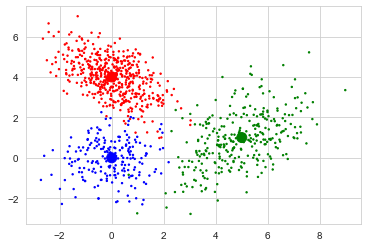

In [121]:
plt.scatter(x[0], x[1], color=string_labels, s=2)
plt.scatter(means[:,0], means[:,1], s=100,  c=np.asarray(["g", "r", "b"]))

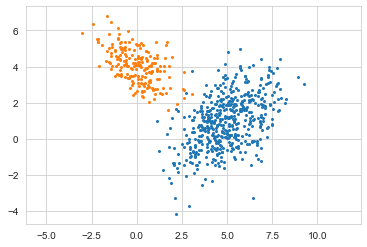

In [17]:
# mean = [5,1]
# cov = [[2,1], [1,2]]  # diagonal covariance

# mean2 = [0, 4]
# cov2 = [[1, -0.5], [-0.5, 1]] 

# import matplotlib.pyplot as plt
# x, y = np.random.multivariate_normal(mean, cov, int(0.5*1000)).T
# x2, y2 = np.random.multivariate_normal(mean2, cov2, int(0.2*1000)).T
# plt.plot(x, y, 'o', markersize=2)
# plt.plot(x2, y2, 'o', markersize=2)
# plt.axis('equal')
# plt.show()

In [ ]:
plt.figure(figsize=(6, 6))

# insert code here

plt.show()

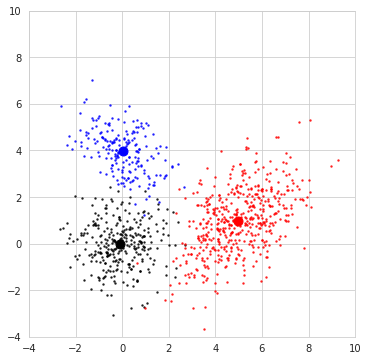

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [129]:
def fit_mog(x,k, niters=10, random_seed=0):
    
    '''Fit Mixture of Gaussian model using EM algo.
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
        
    k: int
        Number of clusters
        
    niters: int
        Maximal number of iterations.
        
    random_seed: int or None
        Random Seed
    
    
    Returnsmog_vectorized = mog
    -------
    
    labels: np.array, (n_samples)
        Cluster labels
        
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    '''

    # fill in your code here
    
    np.random.seed(random_seed)
    model = GaussianMixture(n_components=3, init_params='random')
    model.fit(x)

    means = np.asarray([[5,1], [0,4], [0,0]])
    covs = np.asarray([[[2,1], [1,2]], [[1,-0.5], [-0.5, 1]], [[1,0], [0,1]]])
    ps = np.asarray([0.3, 0.5, 0.2])
    labels, test_data = sample_data(N=1000, m = means, S = covs, p = ps)
    yhat = model.predict(test_data.T)
    
    D = x.shape[1]
    N = x.shape[0]
    
    # -----------
    # init (1 pt)
    # -----------

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------
    # E step
    
    
    return test_data, yhat #(labels, m, S, p)

Run Mixture of Gaussian on toy data

In [130]:
test_data, predict = fit_mog(x.T,3, random_seed=0)
 #mog_labels, m, S, p

(2, 1000)


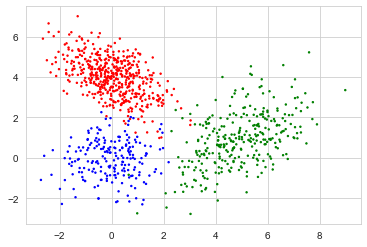

In [133]:
string_predict = predict.astype("str")
string_predict[labels==0] = "g"
string_predict[labels==1] = "r"
string_predict[labels==2] = "b"

plt.scatter(x[0], x[1], color=string_predict, s=2)



Plot toy data with cluster assignments and compare to original labels

In [ ]:
plt.figure(figsize=(12, 6))

# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------

plt.show()


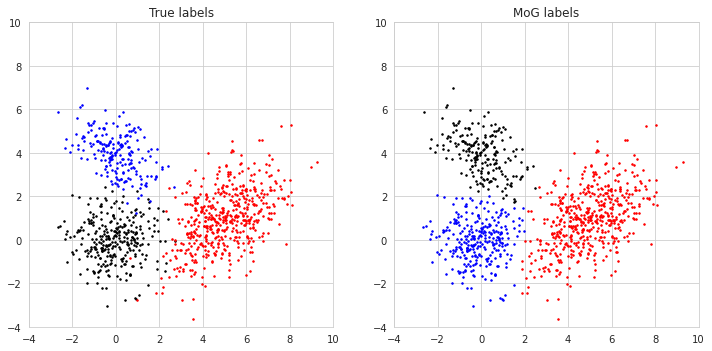

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts + 1 extra pt*



In [ ]:
def mog_bic(x, m, S, p):
    
    '''Compute the BIC for a fitted Mixture of Gaussian model
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_dims, n_dims, n_clusters)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities            
    
    Return
    ------
    
    bic: float
        BIC
        
    LL: float
        Log Likelihood
    '''

    # insert your code here

    N, D = x.shape
    k = m.shape[0]

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    return (bic, LL)
    

In [ ]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (1 extra pts)
# ---------------------------------------------------------------------------------------------------

In [ ]:
plt.figure(figsize=(6,6))

# insert your code here

plt.show()

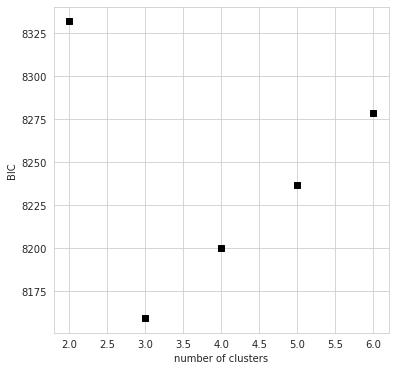

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [ ]:
# --------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (1 pt)
# --------------------------------------------------------------------------

In [ ]:
plt.figure(figsize=(5, 4))

# insert your code here

plt.show()

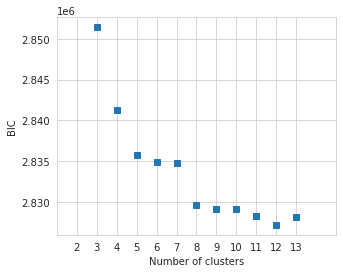

Refit model with lowest BIC and plot data points

In [ ]:
# insert your code here

In [ ]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------

colors = plt.cm.jet(np.linspace(0,1,max(a)+1))

plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

# insert your code here

plt.show()

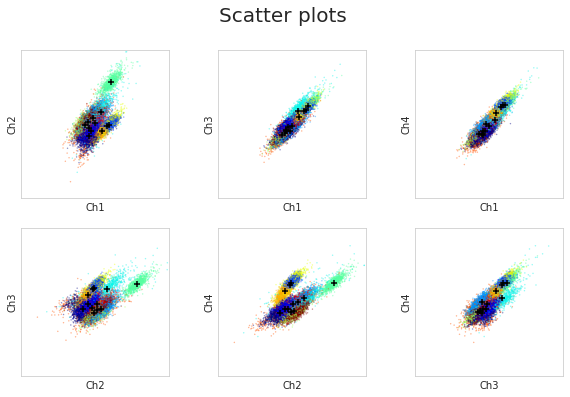

In [ ]:
# np.save('../data/nda_ex_2_means',m)
# np.save('../data/nda_ex_2_covs',S)
# np.save('../data/nda_ex_2_pis',p)
# np.save('../data/nda_ex_2_labels',a)